In [1]:
%load_ext autoreload
%autoreload 0

In [2]:
%autoreload

In [3]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from lib.pandas_util import idxwhere
import sfacts as sf
import numpy as np
import xarray as xr
import seaborn as sns
from scipy.spatial.distance import cdist
import lib.plot

In [5]:
# data/ucfmt.sp-104345.metagenotype.filt-poly05-cvrg05.fit-sfacts44_v-s30-g10000-seed0.world.nc

species_id = '104345'

mgen_stem = f'data/ucfmt.sp-{species_id}.metagenotype.filt-poly05-cvrg05'
scg_path = f'data/ucfmt.sp-{species_id}.derep.genotype.nc'

# fit_path = (f'data/ucfmt.sp-{species_id}.metagenotype'
#             f'.filt-poly05-cvrg05'
#             f'.fit-sfacts47_c1e5-s30-g5000-seed1'
# #             f'.refit-sfacts41-g10000-seed0'
#             f'.world.nc'
#            )

fit_path = f'{mgen_stem}.fit-sfacts44_v-s30-g5000-seed0.refit-sfacts41-g10000-seed0.world.nc'
# fit2_path = (f'data/ucfmt.sp-{species_id}.metagenotype'
#             f'.filt-poly05-cvrg05'
#             f'.fit-sfacts47_c1e5-s30-g5000-seed1'
# #             f'.refit-sfacts41-g10000-seed0'
#             f'.world.nc'
#            )

scg_to_sample_path = f'data/ucfmt.sp-{species_id}.derep.barcode_to_sample.tsv'
library_to_sample_path = "data/ucfmt.barcode_to_sample.tsv"
rabund_threshold = 0.01
pseudo = 0
horizontal_coverage_threshold = 0.05

mgen = sf.data.Metagenotypes.load(f'{mgen_stem}.nc')
drplt = sf.data.Metagenotypes.load(scg_path)
inference = sf.data.World.load(fit_path)




# inference2 = sf.data.World.load(fit2_path)


In [6]:
inference.sizes

Frozen(SortedKeysDict({'strain': 33, 'sample': 109, 'position': 11058, 'allele': 2}))

In [7]:
mgen_consensus = mgen.to_estimated_genotypes(pseudo=pseudo, fillna=False)
scg = drplt.to_estimated_genotypes(pseudo=pseudo, fillna=False)


inferred_geno = inference.genotypes
inferred_comm = inference.communities

# inferred_geno2 = inference2.genotypes
# inferred_comm2 = inference2.communities

position = list(set(scg.position.values) & set(inferred_geno.position.values))
mgen_consensus, scg, inferred_geno = [
    x.mlift("sel", position=position) for x in [mgen_consensus, scg, inferred_geno]
]

mgen_entropy = mgen.entropy("sample")
scg_entropy = drplt.entropy("sample")
comm_entropy = inferred_comm.entropy("sample")
geno_entropy = inferred_geno.entropy("strain")
scg_horizontal_coverage = drplt.horizontal_coverage()
mgen_horizontal_coverage = mgen.horizontal_coverage()

library_to_sample = pd.read_table(
    library_to_sample_path, index_col="barcode", squeeze=True
)
scg_to_sample = pd.read_table(
    scg_to_sample_path, names=["strain", "sample"], index_col="strain", squeeze=True
)
mgen_to_sample = library_to_sample.loc[mgen.sample]


focal_mgen_list = ['SS01009.m']
focal_mgen_consensus = mgen_consensus.mlift('sel', strain=focal_mgen_list)
focal_sample_list = mgen_to_sample.loc[focal_mgen_list].unique()
focal_strain_list = idxwhere((inferred_comm.data.sel(sample=focal_mgen_list) > rabund_threshold).any("sample").to_series())
focal_scg_list = idxwhere(scg_to_sample.loc[idxwhere(scg_horizontal_coverage.to_series() > horizontal_coverage_threshold)].isin(focal_sample_list))
focal_scg = scg.mlift('sel', strain=focal_scg_list)
focal_geno = inferred_geno.mlift('sel', strain=focal_strain_list)


# comm_entropy2 = inferred_comm2.entropy("sample")
# geno_entropy2 = inferred_geno2.entropy("strain")
# focal_strain_list2 = idxwhere((inferred_comm2.data.sel(sample=focal_mgen_list) > rabund_threshold).any("sample").to_series())
# focal_geno2 = inferred_geno2.mlift('sel', strain=focal_strain_list2)

focal_mgen_list, focal_sample_list, focal_strain_list, len(focal_scg_list)

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


(['SS01009.m'], array(['SS01009'], dtype=object), [2, 5, 24, 28], 62)

In [8]:
len(library_to_sample.unique())

159

In [9]:
inferred_comm.sel(strain=focal_strain_list, sample=focal_mgen_list).to_series()

sample     strain
SS01009.m  2         0.324942
           5         0.565227
           24        0.030555
           28        0.074015
Name: communities, dtype: float32

In [10]:
from scipy.spatial.distance import pdist, squareform

def masked_hamming_distance(x, y):
    mask = ~(np.isnan(x) | np.isnan(y))
    diff = np.abs(x - y)
    return diff[mask].sum() / np.ones_like(diff)[mask].sum()

def genotype_mhd_pdist(genotypes):
    return pd.DataFrame(squareform(pdist(genotypes.values, metric=masked_hamming_distance)), index=genotypes.strain, columns=genotypes.strain)

genotype_mhd_pdist(focal_scg.discretized())

strain,SS01009_1,SS01009_101,SS01009_102,SS01009_103,SS01009_104,SS01009_105,SS01009_106,SS01009_107,SS01009_108,SS01009_109,...,SS01009_90,SS01009_91,SS01009_92,SS01009_93,SS01009_94,SS01009_95,SS01009_96,SS01009_97,SS01009_98,SS01009_99
strain,,,,,,,,,,,,,,,,,,,,,
SS01009_1,0.000000,0.035398,0.233564,0.025225,0.030476,0.027491,0.035714,0.034483,0.018433,0.179650,...,0.027190,0.031026,0.023196,0.018382,0.031429,0.036855,0.034031,0.014134,0.035519,0.212963
SS01009_101,0.035398,0.000000,0.161917,0.002878,0.006402,0.010309,0.008264,0.001406,0.002853,0.154110,...,0.004525,0.008210,0.006410,0.000000,0.021930,0.007519,0.002016,0.004619,0.017717,0.192869
SS01009_102,0.233564,0.161917,0.000000,0.189716,0.206897,0.197861,0.189046,0.194561,0.199623,0.153846,...,0.192612,0.184061,0.158009,0.169231,0.219321,0.192488,0.176039,0.173410,0.167401,0.206612
SS01009_103,0.025225,0.002878,0.189716,0.000000,0.008913,0.012281,0.006012,0.001919,0.002004,0.142638,...,0.010989,0.009639,0.002045,0.007937,0.014205,0.007426,0.008721,0.002967,0.012469,0.182898
SS01009_104,0.030476,0.006402,0.206897,0.008913,0.000000,0.012800,0.005425,0.008389,0.005525,0.179806,...,0.007092,0.013245,0.011407,0.018987,0.020588,0.006742,0.005000,0.008499,0.021378,0.216433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SS01009_95,0.036855,0.007519,0.192488,0.007426,0.006742,0.020202,0.007772,0.005556,0.005128,0.134725,...,0.003571,0.006270,0.013477,0.004785,0.021186,0.000000,0.003731,0.007905,0.025000,0.204678
SS01009_96,0.034031,0.002016,0.176039,0.008721,0.005000,0.005348,0.005277,0.005348,0.002591,0.166302,...,0.003759,0.006006,0.008850,0.005464,0.007299,0.003731,0.000000,0.000000,0.008065,0.230061
SS01009_97,0.014134,0.004619,0.173410,0.002967,0.008499,0.006154,0.003205,0.003390,0.010601,0.223278,...,0.009950,0.003876,0.004016,0.000000,0.010204,0.007905,0.000000,0.000000,0.018605,0.159574


In [11]:
from sklearn.cluster import AgglomerativeClustering
clust = pd.Series(AgglomerativeClustering(n_clusters=None, distance_threshold=0.15, linkage='complete', affinity='precomputed').fit(genotype_mhd_pdist(focal_scg.discretized())).labels_, index=focal_scg.strain)
clust.value_counts()

0    48
2     7
1     6
3     1
dtype: int64

In [12]:
for x in inferred_comm.sel(strain=focal_strain_list, sample=focal_mgen_list[0]).to_series().sort_values(ascending=False).iteritems():
    print(x)

(5, 0.5652270317077637)
(2, 0.32494163513183594)
(28, 0.0740152969956398)
(24, 0.030555378645658493)


No handles with labels found to put in legend.


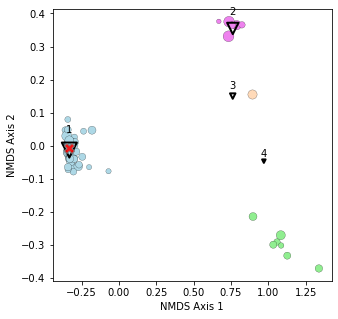

In [13]:
together = sf.data.Genotypes.concat(dict(
    scg=focal_scg,
    mgen=focal_mgen_consensus,
#     dmgen=focal_mgen_consensus.discretized(),
#     strain0=focal_geno,
#     dstrain0=focal_geno.discretized(),
#     strain1=focal_geno2,
    strain=focal_geno,
), dim='strain')

meta=pd.DataFrame(dict(
    geno_type=together.strain.to_series().str.split('_', 1).apply(lambda x: x[0]),
    original_label=together.strain.to_series().str.split('_', 1).apply(lambda x: x[1]),
), index=together.strain).fillna(-1)
meta['clust'] = clust.rename(lambda s: 'scg_' + s)
meta['clust'] = meta.clust.fillna(-1)
meta['zorder'] = meta.geno_type.map(dict(scg=0, strain=1, mgen=2))
meta['show'] = (meta.geno_type == 'scg')  # | (meta.geno_type == 'mgen')


# meta['markersize'] = meta.geno_type.map({'scg': 40, 'mgen': 100, 'dstrain0': 100})

strain_markersize = pd.concat([
    _comm.sel(strain=_strain_list, sample=focal_mgen_list[0]).to_series().rename(lambda i: _label + '_' + str(i)) * 400
    for _label, _comm, _strain_list in [
#         ('strain1', inferred_comm, focal_strain_list),
        ('strain', inferred_comm, focal_strain_list)
#         ('strain0', inferred_comm, focal_strain_list),
#         ('strain1', inferred_comm2, focal_strain_list2)
    ]
])

meta.loc[strain_markersize.index, 'markersize'] = strain_markersize
meta.loc[meta.geno_type == 'scg', 'markersize'] = scg_horizontal_coverage.to_series().rename(lambda s: 'scg_' + s) * 400
meta.loc[meta.geno_type == 'mgen', 'markersize'] = 100

#meta['markersize']

colorby = 'clust'
color_palette = {-1.0: 'black', 0.0: 'lightblue', 1.0: 'violet', 2.0: 'lightgreen', 3.0: 'peachpuff', 4.0: 'orange'}

markerby = 'geno_type'
marker_palette = dict(scg='o', strain='^', mgen='s')

fig, ax = plt.subplots(figsize=(5, 5))

ax, ordin, *_ = lib.plot.ordination_plot(
    genotype_mhd_pdist(together.discretized()),
    ordin=lib.plot.pca_ordination,
    meta=meta,
    showby='show',
#     colorby='geno_type',
    colorby=colorby,
    color_palette=color_palette,
#     color_palette=dict(scg='black', strain0='lightblue', dstrain0='blue', strain1='violet', dstrain1='purple', mgen='green'),
    markerby=markerby,
#     marker_palette={-1.0: 'o', 0.0: 'v', 1.0: '>', 2.0: '<', 3.0: 's'},
    marker_palette=marker_palette,
    zorderby='zorder',
#     zorderby_palette=dict(scg=0, strain0=1, dstrain0=2, strain1=1, dstrain1=3, mgen=3),
    markersizeby='markersize',
#     markersize_palette=markersize_palette,
    ordin_kws=dict(),
#     fill_legend=False,
    scatter_kws=dict(lw=0.2, alpha=1.0),
    ax=ax,
    fill_legend=False,
)

ax.set_xlabel('NMDS Axis 1')
ax.set_ylabel('NMDS Axis 2')

for i, (_strain, _) in enumerate(inferred_comm.sel(strain=focal_strain_list, sample=focal_mgen_list[0]).to_series().sort_values(ascending=False).iteritems(), start=1):
    for prefix in ['strain']:
        _key = f'{prefix}_{_strain}'
        ordin_data = ordin.loc[_key]
        x, y = tuple(ordin.loc[_key][['PC1', 'PC2']].to_list())
        offset = meta.loc[_key, 'markersize']**(1/3) / 100
        ax.scatter(x, y, marker='v', facecolor='none', edgecolor='black', s=ordin_data['markersize'], zorder=3, lw=2)
        ax.annotate(i, xy=(x, y + offset), ha='center', va='center')



for i, clust_letter in zip(sorted(meta.clust.unique()), ['__nolegend__', 'A', 'B', 'C', 'D']):
    if i == -1:
        continue
    plt.scatter([], [], marker=marker_palette['scg'], color=color_palette[i], lw=0.2, edgecolor='grey', label=f'Cluster {clust_letter}')
    
_key = f'mgen_{focal_mgen_list[0]}'
ordin_data = ordin.loc[_key]
x, y = tuple(ordin.loc[_key][['PC1', 'PC2']].to_list())
ax.scatter(x, y, marker='X', facecolor='red', edgecolor='grey', alpha=0.9, zorder=4, s=ordin_data['markersize'], label='Metagenotype')

        
for gen_type_label, _gen_type in [
#     ('Metagenotype', 'mgen'),
#     ('StrainFacts', 'dstrain0'),
#     ('StrainFacts', 'strain0'),
    ('StrainFacts', 'strain'),
#     ('StrainFacts fuzzy', 'strain0'),
]:
    plt.scatter([], [], marker=marker_palette[_gen_type], edgecolor='black', facecolor='None', label=gen_type_label)

ax.legend(bbox_to_anchor=(1., 1.0), ncol=1)
ax.get_legend().remove()

fig.savefig('fig/scg_ordination_104345_full.pdf', dpi=400, pad_inches='tight')

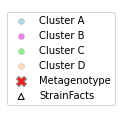

In [14]:
fig, ax = plt.subplots(figsize=(2, 2))

for i, clust_letter in zip(sorted(meta.clust.unique()), ['__nolegend__', 'A', 'B', 'C', 'D']):
    if i == -1:
        continue
    plt.scatter([], [], marker=marker_palette['scg'], color=color_palette[i], lw=0.2, edgecolor='grey', label=f'Cluster {clust_letter}')
    
_key = f'mgen_{focal_mgen_list[0]}'
ordin_data = ordin.loc[_key]
x, y = tuple(ordin.loc[_key][['PC1', 'PC2']].to_list())
ax.scatter([], [], marker='X', facecolor='red', edgecolor='grey', alpha=0.9, zorder=4, s=ordin_data['markersize'], label='Metagenotype')

        
for gen_type_label, _gen_type in [
#     ('Metagenotype', 'mgen'),
#     ('StrainFacts', 'dstrain0'),
#     ('StrainFacts', 'strain0'),
    ('StrainFacts', 'strain'),
#     ('StrainFacts fuzzy', 'strain0'),
]:
    plt.scatter([], [], marker=marker_palette[_gen_type], edgecolor='black', facecolor='None', label=gen_type_label)

ax.legend()
ax.axis('off')

fig.savefig('fig/scg_ordination_104345_legend.pdf', dpi=400)

In [15]:
scg_matching = pd.DataFrame(dict(
    strain=sf.evaluation.match_genotypes(
        focal_scg.discretized().to_world(),
        focal_geno.discretized().to_world(),
        cdist=lambda xx, yy: cdist(xx, yy, metric=masked_hamming_distance),
    )[0],
    strain_dist=sf.evaluation.match_genotypes(
        focal_scg.discretized().to_world(),
        focal_geno.discretized().to_world(),
        cdist=lambda xx, yy: cdist(xx, yy, metric=masked_hamming_distance),
    )[1],
    clust=clust,
)).rename_axis(index='scg')

(
    scg_matching
    .groupby(['clust', 'strain'])
    .strain_dist
    .agg(['count', 'median'])
    .apply(lambda x: f'{x["count"]} ({x["median"]:0.2})', axis=1)
    .unstack('clust', fill_value=0)
    .join(inferred_comm.sel(strain=focal_strain_list, sample=focal_mgen_list[0]).to_series())
    .sort_values('communities', ascending=False)
)

,0,1,2,3,communities
strain,,,,,
5,48.0 (0.006),0,1.0 (0.18),0,0.565227
2,0,6.0 (0.0078),3.0 (0.19),0,0.324942
28,0,0,0,1.0 (0.02),0.074015
24,0,0,3.0 (0.19),0,0.030555


In [16]:
scg_matching.groupby(['clust', 'strain']).agg(['count', 'mean'])#[d.scg_match==24]#

strain_dist          
                   count      mean
clust strain                      
0     5               48  0.009073
1     2                6  0.012702
2     2                3  0.188132
      5                1  0.180648
      24               3  0.186055
3     28               1  0.020210

In [17]:
inferred_comm.sel(strain=focal_strain_list, sample=focal_mgen_list[0]).to_series()

strain
2     0.324942
5     0.565227
24    0.030555
28    0.074015
Name: communities, dtype: float32

/pollard/home/bsmith/Projects/StrainFacts/sfacts/plot.py:143: UserWarning: col_linkage calculation failed: Distance matrix 'X' must be symmetric.
  warnings.warn(f"col_linkage calculation failed: {err}")
/pollard/home/bsmith/Projects/StrainFacts/sfacts/plot.py:155: UserWarning: row_linkage calculation failed: Distance matrix 'X' must be symmetric.
  warnings.warn(f"row_linkage calculation failed: {err}")


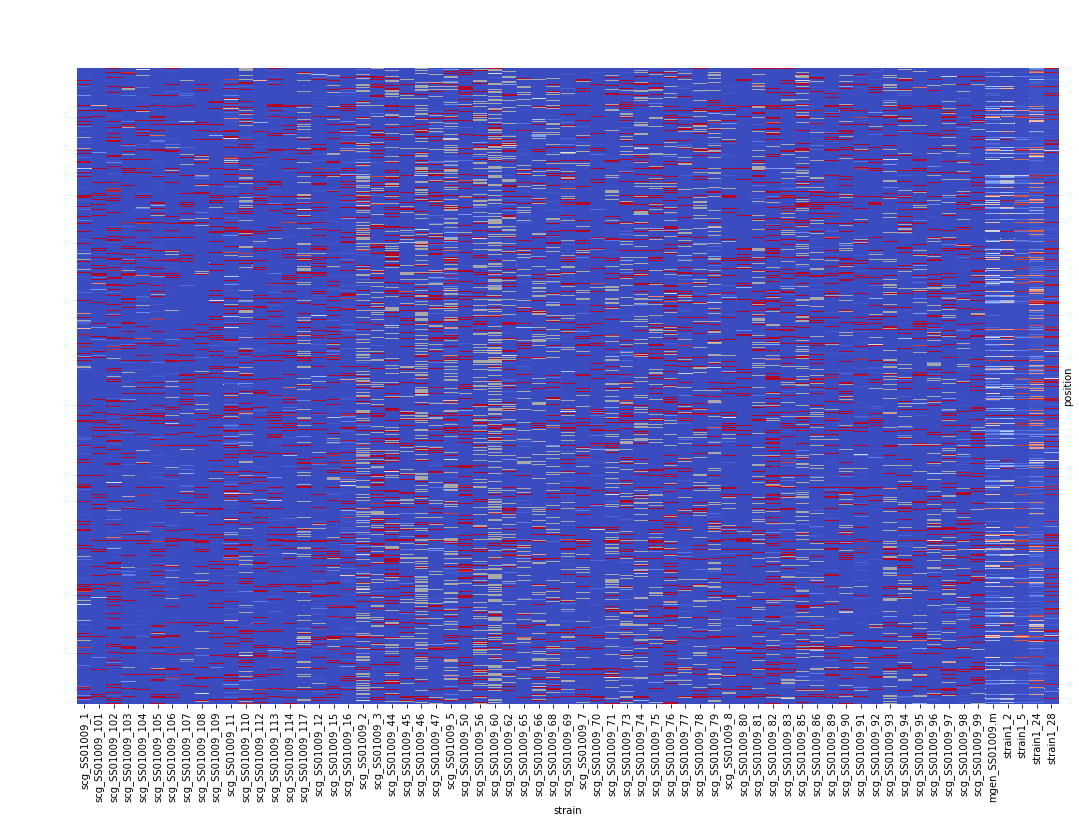

In [18]:
together = sf.data.Genotypes.concat(dict(
    scg=focal_scg,
    mgen=focal_mgen_consensus,
#     dmgen=focal_mgen_consensus.discretized(),
#     strain0=focal_geno,
#     dstrain0=focal_geno.discretized(),
    strain1=focal_geno,
#     dstrain1=focal_geno2.discretized(),
), dim='strain')

sf.plot.plot_genotype(together, transpose=True, scalex=1e-3)

No handles with labels found to put in legend.


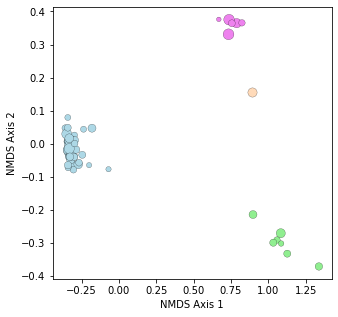

In [19]:
together = sf.data.Genotypes.concat(dict(
    scg=focal_scg,
    mgen=focal_mgen_consensus,
#     dmgen=focal_mgen_consensus.discretized(),
#     strain0=focal_geno,
#     dstrain0=focal_geno.discretized(),
#     strain1=focal_geno2,
    strain=focal_geno,
), dim='strain')

meta=pd.DataFrame(dict(
    geno_type=together.strain.to_series().str.split('_', 1).apply(lambda x: x[0]),
    original_label=together.strain.to_series().str.split('_', 1).apply(lambda x: x[1]),
), index=together.strain).fillna(-1)
meta['clust'] = clust.rename(lambda s: 'scg_' + s)
meta['clust'] = meta.clust.fillna(-1)
meta['zorder'] = meta.geno_type.map(dict(scg=0, strain=1, mgen=2))
meta['show'] = (meta.geno_type == 'scg')  # | (meta.geno_type == 'mgen')


# meta['markersize'] = meta.geno_type.map({'scg': 40, 'mgen': 100, 'dstrain0': 100})

strain_markersize = pd.concat([
    _comm.sel(strain=_strain_list, sample=focal_mgen_list[0]).to_series().rename(lambda i: _label + '_' + str(i)) * 400
    for _label, _comm, _strain_list in [
#         ('strain1', inferred_comm, focal_strain_list),
        ('strain', inferred_comm, focal_strain_list)
#         ('strain0', inferred_comm, focal_strain_list),
#         ('strain1', inferred_comm2, focal_strain_list2)
    ]
])

meta.loc[strain_markersize.index, 'markersize'] = strain_markersize
meta.loc[meta.geno_type == 'scg', 'markersize'] = scg_horizontal_coverage.to_series().rename(lambda s: 'scg_' + s) * 400
meta.loc[meta.geno_type == 'mgen', 'markersize'] = 100

#meta['markersize']

colorby = 'clust'
color_palette = {-1.0: 'black', 0.0: 'lightblue', 1.0: 'violet', 2.0: 'lightgreen', 3.0: 'peachpuff', 4.0: 'orange'}

markerby = 'geno_type'
marker_palette = dict(scg='o', strain='^', mgen='s')

fig, ax = plt.subplots(figsize=(5, 5))

ax, ordin, *_ = lib.plot.ordination_plot(
    genotype_mhd_pdist(together.discretized()),
    ordin=lib.plot.pca_ordination,
    meta=meta,
    showby='show',
#     colorby='geno_type',
    colorby=colorby,
    color_palette=color_palette,
#     color_palette=dict(scg='black', strain0='lightblue', dstrain0='blue', strain1='violet', dstrain1='purple', mgen='green'),
    markerby=markerby,
#     marker_palette={-1.0: 'o', 0.0: 'v', 1.0: '>', 2.0: '<', 3.0: 's'},
    marker_palette=marker_palette,
    zorderby='zorder',
#     zorderby_palette=dict(scg=0, strain0=1, dstrain0=2, strain1=1, dstrain1=3, mgen=3),
    markersizeby='markersize',
#     markersize_palette=markersize_palette,
    ordin_kws=dict(),
#     fill_legend=False,
    scatter_kws=dict(lw=0.2, alpha=1.0),
    ax=ax,
    fill_legend=False,
)

ax.set_xlabel('NMDS Axis 1')
ax.set_ylabel('NMDS Axis 2')

# for i, (_strain, _) in enumerate(inferred_comm.sel(strain=focal_strain_list, sample=focal_mgen_list[0]).to_series().sort_values(ascending=False).iteritems()):
#     for prefix in ['strain']:
#         _key = f'{prefix}_{_strain}'
#         ordin_data = ordin.loc[_key]
#         x, y = tuple(ordin.loc[_key][['PC1', 'PC2']].to_list())
#         offset = meta.loc[_key, 'markersize']**(1/3) / 100
#         ax.scatter(x, y, marker='v', facecolor='none', edgecolor='black', s=ordin_data['markersize'], zorder=3, lw=2)
#         ax.annotate(i, xy=(x, y + offset), ha='center', va='center')



# for i, clust_letter in zip(sorted(meta.clust.unique()), ['__nolegend__', 'A', 'B', 'C', 'D']):
#     if i == -1:
#         continue
#     plt.scatter([], [], marker=marker_palette['scg'], color=color_palette[i], lw=0.2, edgecolor='grey', label=f'Cluster {clust_letter}')
    
# _key = f'mgen_{focal_mgen_list[0]}'
# ordin_data = ordin.loc[_key]
# x, y = tuple(ordin.loc[_key][['PC1', 'PC2']].to_list())
# ax.scatter(x, y, marker='X', facecolor='red', edgecolor='grey', alpha=0.9, zorder=4, s=ordin_data['markersize'], label='Metagenotype')

        
# for gen_type_label, _gen_type in [
# #     ('Metagenotype', 'mgen'),
# #     ('StrainFacts', 'dstrain0'),
# #     ('StrainFacts', 'strain0'),
#     ('StrainFacts', 'strain'),
# #     ('StrainFacts fuzzy', 'strain0'),
# ]:
#     plt.scatter([], [], marker=marker_palette[_gen_type], edgecolor='black', facecolor='None', label=gen_type_label)

# ax.legend(bbox_to_anchor=(1., 1.0), ncol=1)
ax.get_legend().remove()

fig.savefig('fig/scg_ordination_104345_only_scg.png', dpi=400, pad_inches='tight')

No handles with labels found to put in legend.


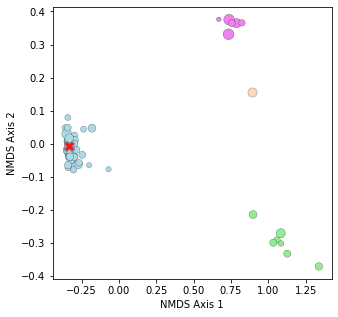

In [20]:
together = sf.data.Genotypes.concat(dict(
    scg=focal_scg,
    mgen=focal_mgen_consensus,
#     dmgen=focal_mgen_consensus.discretized(),
#     strain0=focal_geno,
#     dstrain0=focal_geno.discretized(),
#     strain1=focal_geno2,
    strain=focal_geno,
), dim='strain')

meta=pd.DataFrame(dict(
    geno_type=together.strain.to_series().str.split('_', 1).apply(lambda x: x[0]),
    original_label=together.strain.to_series().str.split('_', 1).apply(lambda x: x[1]),
), index=together.strain).fillna(-1)
meta['clust'] = clust.rename(lambda s: 'scg_' + s)
meta['clust'] = meta.clust.fillna(-1)
meta['zorder'] = meta.geno_type.map(dict(scg=0, strain=1, mgen=2))
meta['show'] = (meta.geno_type == 'scg')  # | (meta.geno_type == 'mgen')


# meta['markersize'] = meta.geno_type.map({'scg': 40, 'mgen': 100, 'dstrain0': 100})

strain_markersize = pd.concat([
    _comm.sel(strain=_strain_list, sample=focal_mgen_list[0]).to_series().rename(lambda i: _label + '_' + str(i)) * 400
    for _label, _comm, _strain_list in [
#         ('strain1', inferred_comm, focal_strain_list),
        ('strain', inferred_comm, focal_strain_list)
#         ('strain0', inferred_comm, focal_strain_list),
#         ('strain1', inferred_comm2, focal_strain_list2)
    ]
])

meta.loc[strain_markersize.index, 'markersize'] = strain_markersize
meta.loc[meta.geno_type == 'scg', 'markersize'] = scg_horizontal_coverage.to_series().rename(lambda s: 'scg_' + s) * 400
meta.loc[meta.geno_type == 'mgen', 'markersize'] = 100

#meta['markersize']

colorby = 'clust'
color_palette = {-1.0: 'black', 0.0: 'lightblue', 1.0: 'violet', 2.0: 'lightgreen', 3.0: 'peachpuff', 4.0: 'orange'}

markerby = 'geno_type'
marker_palette = dict(scg='o', strain='^', mgen='s')

fig, ax = plt.subplots(figsize=(5, 5))

ax, ordin, *_ = lib.plot.ordination_plot(
    genotype_mhd_pdist(together.discretized()),
    ordin=lib.plot.pca_ordination,
    meta=meta,
    showby='show',
#     colorby='geno_type',
    colorby=colorby,
    color_palette=color_palette,
#     color_palette=dict(scg='black', strain0='lightblue', dstrain0='blue', strain1='violet', dstrain1='purple', mgen='green'),
    markerby=markerby,
#     marker_palette={-1.0: 'o', 0.0: 'v', 1.0: '>', 2.0: '<', 3.0: 's'},
    marker_palette=marker_palette,
    zorderby='zorder',
#     zorderby_palette=dict(scg=0, strain0=1, dstrain0=2, strain1=1, dstrain1=3, mgen=3),
    markersizeby='markersize',
#     markersize_palette=markersize_palette,
    ordin_kws=dict(),
#     fill_legend=False,
    scatter_kws=dict(lw=0.2, alpha=1.0),
    ax=ax,
    fill_legend=False,
)

ax.set_xlabel('NMDS Axis 1')
ax.set_ylabel('NMDS Axis 2')

# for i, (_strain, _) in enumerate(inferred_comm.sel(strain=focal_strain_list, sample=focal_mgen_list[0]).to_series().sort_values(ascending=False).iteritems()):
#     for prefix in ['strain']:
#         _key = f'{prefix}_{_strain}'
#         ordin_data = ordin.loc[_key]
#         x, y = tuple(ordin.loc[_key][['PC1', 'PC2']].to_list())
#         offset = meta.loc[_key, 'markersize']**(1/3) / 100
#         ax.scatter(x, y, marker='v', facecolor='none', edgecolor='black', s=ordin_data['markersize'], zorder=3, lw=2)
#         ax.annotate(i, xy=(x, y + offset), ha='center', va='center')



# for i, clust_letter in zip(sorted(meta.clust.unique()), ['__nolegend__', 'A', 'B', 'C', 'D']):
#     if i == -1:
#         continue
#     plt.scatter([], [], marker=marker_palette['scg'], color=color_palette[i], lw=0.2, edgecolor='grey', label=f'Cluster {clust_letter}')
    
_key = f'mgen_{focal_mgen_list[0]}'
ordin_data = ordin.loc[_key]
x, y = tuple(ordin.loc[_key][['PC1', 'PC2']].to_list())
ax.scatter(x, y, marker='X', facecolor='red', edgecolor='grey', alpha=0.9, zorder=4, s=ordin_data['markersize'], label='Metagenotype')

        
# for gen_type_label, _gen_type in [
# #     ('Metagenotype', 'mgen'),
# #     ('StrainFacts', 'dstrain0'),
# #     ('StrainFacts', 'strain0'),
#     ('StrainFacts', 'strain'),
# #     ('StrainFacts fuzzy', 'strain0'),
# ]:
#     plt.scatter([], [], marker=marker_palette[_gen_type], edgecolor='black', facecolor='None', label=gen_type_label)

# ax.legend(bbox_to_anchor=(1., 1.0), ncol=1)
ax.get_legend().remove()

fig.savefig('fig/scg_ordination_104345_scg_and_mgen.png', dpi=400, pad_inches='tight')